Specify the folder where `jpq/` is installed, and import the library:

In [1]:
containing_folder = '/home/kunal/Desktop/'
import sys
sys.path.insert(0, containing_folder)
from jpq import *
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

# Circuits in color

## Embedded qubits

In [2]:
KNOWN_GATES = {
    'x': SigmaX,
    'y': SigmaY,
    'z': SigmaZ,
    'h': lambda: (1/np.sqrt(2))*np.array([[1, 1], [1, -1]]),
    's': lambda: np.array([[1, 0], [0, 1j]]),
    't': lambda: np.array([[1, 0], [0, (1+1j)/np.sqrt(2)]])
}


def embedded_1qubit(label, width):
    """channel of embedded 1-qubit gate in circuit of given width"""
    tstr = label[0]
    idx = label[1]

    try:
        g = KNOWN_GATES[tstr]()
    except KeyError as e:
        raise ValueError(f"tchar '{tstr}' not in dictionary") from e
    
    unitary = 1
    for w in range(width):
        u_i = g if w == idx else np.eye(2, dtype=complex)
        unitary = np.kron(unitary, u_i)
    return unitary

In [3]:
def embedded_controlledU(cbit, tbit, width, U):
    """
    make unitary operation for C_U 
    [|0><0| o ... o 1] + [|1><1| o ... o U] 
    """
    assert U.shape[0] == 2 and U.shape[1] == 2, \
        "makeCU: dimension mismatch"
    I = np.eye(2, dtype=complex)
    
    m0 = 1
    m1 = 1
    for i in range(width):
        if i == cbit:
            m0 = np.kron(m0, np.array([[1, 0], [0, 0]]))
            m1 = np.kron(m1, np.array([[0, 0], [0, 1]]))
        elif i == tbit:
            m0 = np.kron(m0, I)
            m1 = np.kron(m1, U)
        else:
            m0 = np.kron(m0, I)
            m1 = np.kron(m1, I)
    return m0 + m1

## Converting layers to channels

In [4]:
def label2channel(label, width):
    if(label[0][0] == 'c'):
        # controlled operation
        op = label[0]
        if(op == 'cx'):
            g = SigmaX()
        elif(op == 'cy'):
            g = SigmaY()
        elif(op == 'cz'):
            g = SigmaZ()
        else:
            raise ValueError(f"tchar {op} not in dictionary")
        U = embedded_controlledU(label[1], label[2], width, g)
    else:
        # otherwise, 1-qubit unitary assumed
        U = embedded_1qubit(label, width)
    return Channel([U], rep='kraus')

In [5]:
def layer2channel(layer, width):
    if len(layer) > 0: 
        chnl = label2channel(layer[0], width)
        if(len(layer) > 1):
            for c in layer[1:]:
                # TODO i'm not sure this works
                chnl = compose(label2channel(c, width), chnl)
        return chnl

## Circuit class

In [6]:
class Circuit():
    def __init__(self, width, layers=None):
        self._width = width
        self._layers = layers

    def get_layer_channel(self, i):
        """Get the ith layer channel class"""
        if (i > len(self._layers) - 1):
            raise ValueError("requested layer exceeds numbers of layers in circuit")
        return(layer2channel(self._layers[i], self._width))

    def get_width(self):
        return self._width

    def get_depth(self):
        return len(self._layers)

    def get_layer(self, idx):
        return self._layers[idx]

## Painting the circuit

In [37]:
def paint_X(draw, bit, gate_name, layer_idx, tileDims, gateRatio):
    """For now, let's just paint a black box
    we'll specialize this function to paint specific gates
    in our gate set
    """
    dimX = tileDims[0]
    dimY = tileDims[1]
    dims = [((layer_idx+1-gateRatio)*dimX, (bit+0.5-gateRatio)*dimY), 
            ((layer_idx+1+gateRatio)*dimX, (bit+0.5+gateRatio)*dimY)]
    draw.rectangle(dims, fill='black')
    fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", int(gateRatio*2*dimY))
    lenth = draw.textlength(gate_name.upper(), font=fnt) 
    draw.text(((layer_idx+1)*dimX - lenth/2, dims[0][1]), gate_name.upper(), font=fnt)

def paint_controlledU(draw, cbit, tbit, gate_name, layer_idx, tileDims, gateRatio):
    """
    paints a black box and circle for now, and a line that connects them
    """
    dimX = tileDims[0]
    dimY = tileDims[1]

    line = [((layer_idx+1)*dimX, (cbit+0.5)*dimY),
           ((layer_idx+1)*dimX, (tbit+0.5)*dimY)]
    draw.rectangle(line, fill='black')

    dims = [((layer_idx+1-gateRatio)*dimX, (cbit+0.5-gateRatio)*dimY), 
            ((layer_idx+1+gateRatio)*dimX, (cbit+0.5+gateRatio)*dimY)]
    draw.ellipse(dims, fill='black')
    
    paint_X(draw, tbit, gate_name[1:], layer_idx, tileDims, gateRatio)
    
def paint_gates(image, layer, idx, tileDims, gateRatio=1/4):
    """Paint the gates"""
    for lbl in layer:
        # this will become a switch-type interface 
        draw = ImageDraw.Draw(image)
        if lbl[0][0] == 'c':
            paint_controlledU(draw, lbl[1], lbl[2], lbl[0], idx, tileDims, gateRatio)
        else:
            paint_X(draw, lbl[1], lbl[0], idx, tileDims, gateRatio)

In [38]:
def local_bloch(state, subsystem, qubits):
    dims = [2 for _ in range(qubits)]
    traced = [j for j in range(qubits) if j != subsystem]
    rho = TrX(state, traced, dims)
    # the trace should be real
    return [np.trace(rho@SigmaX()).real, np.trace(rho@SigmaY()).real, np.trace(rho@SigmaZ()).real]

In [39]:
class Painter():
    def __init__(self, tileDims=(50,50), wireRatio=1/4):
        self._tileDims = tileDims
        self._wireRatio = wireRatio

    def paint(self, circ, filename=None):
        """Paint the circuit"""
        # imput params
        qbits = circ.get_width()
        depth = circ.get_depth()
        tileX = self._tileDims[0]
        tileY = self._tileDims[1]
        wireRatio = self._wireRatio
        rho = Register(qbits).mat()
        
        # [1] Allocate image 
        image = Image.new("RGBA", (tileX*(depth+2), tileY*qbits), (0, 0, 0, 0))
        draw = ImageDraw.Draw(image)
        
        # paint initial layer of tiles
        for q in range(qbits):
            xyz = local_bloch(rho, q, qbits)
            [r,g,b] =  [int(255*(1+xyz[v])/2) for v in range(3)]
            xi, yi = int(0), int((q+0.5)*tileY)
            xf, yf = int(tileX), int(yi)
            draw.line([(xi, yi), (xf, yf)], width=int(tileY*wireRatio), fill=(r, g, b))
        
        # painter circuit layers
        for i in range(depth):
            channel = circ.get_layer_channel(i)
            rho = channel.apply(rho)
            for q in range(qbits):
                xyz = local_bloch(rho, q, qbits)
                [r,g,b] =  [int(255*(1+xyz[v])/2) for v in range(3)]
                xi, yi = int((i+1)*tileX), int((q+0.5)*tileY)
                xf, yf = int((i+2)*tileX), int(yi)
                draw.line([(xi, yi), (xf, yf)], width=int(tileY*wireRatio), fill=(r, g, b))
            layer = circ.get_layer(i)
            paint_gates(image, layer, i, (tileX, tileY))
        
        if filename:
            image.save(filename)
        return image

## Examples

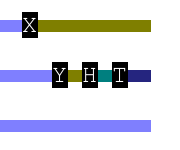

In [40]:
layers = [[('x', 0)], [('y', 1)], [('h', 1)], [('t', 1)]]
circ = Circuit(3, layers)
painter = Painter((30, 50))
painter.paint(circ)

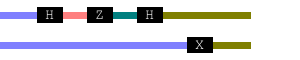

In [41]:
layers = [[('h', 0)], [('z', 0)], [('h', 0)], [ ('x', 1)]]
circ = Circuit(2, layers)
painter = Painter((50, 30))
painter.paint(circ)

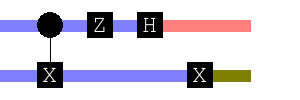

In [47]:
layers = [[('cx', 0, 1)], [('z', 0)], [('h', 0)], [ ('x', 1)]]
circ = Circuit(2, layers)
painter = Painter()
painter.paint(circ)

### Random Example

In [43]:
def random_circuit_XYZHSTCnot_1D(depth, qubits):
    layers = []
    for l in range(depth):
        i = random.randint(1, 7)
        if i == 1: # X-type
            j = random.randint(0, qubits-1)
            layers.append([('x', j)])
        elif i == 2: # Y-type
            j = random.randint(0, qubits-1)
            layers.append([('y', j)])
        elif i == 3: # Z-type
            j = random.randint(0, qubits-1)
            layers.append([('z', j)])
        elif i == 4: # H-type
            j = random.randint(0, qubits-1)
            layers.append([('h', j)])
        elif i == 5: # S-type
            j = random.randint(0, qubits-1)
            layers.append([('s', j)])
        elif i == 6: # T-type
            j = random.randint(0, qubits-1)
            layers.append([('t', j)])
        elif i == 7: # Cnot-type (only neighbors)
            j = random.randint(0, qubits-1)
            k = random.randint(0, qubits-1)
            while k == j:
                k = random.randint(0, qubits-1)
            layers.append([('cx', j, k)])
                
    return layers

[[('cx', 3, 0)], [('z', 1)], [('h', 0)], [('s', 1)], [('s', 1)], [('s', 0)], [('x', 2)]]


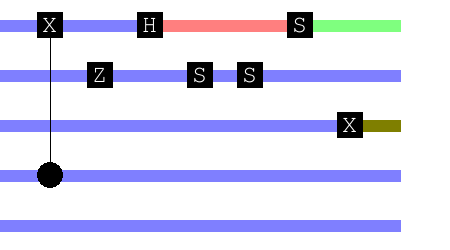

In [44]:
layers = random_circuit_XYZHSTCnot_1D(7,4)
print(layers)
circ = Circuit(5, layers)
painter = Painter()
painter.paint(circ)

### 5-bit ECC example

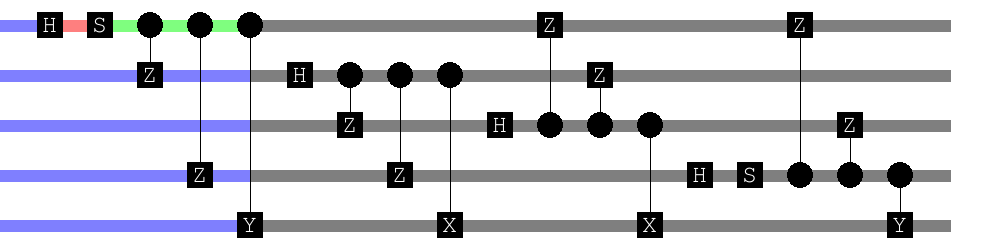

In [45]:
C5bitCode = [
    [('h', 0)], 
    [('s', 0)], 
    [('cz', 0, 1)],
    [('cz', 0, 3)],
    [('cy', 0, 4)],
    [('h', 1)],
    [('cz', 1, 2)],
    [('cz', 1, 3)],
    [('cx', 1, 4)], 
    [('h', 2)], 
    [('cz', 2, 0)], 
    [('cz', 2, 1)], 
    [('cx', 2, 4)],
    [('h', 3)], 
    [('s', 3)],
    [('cz', 3, 0)], 
    [('cz', 3, 2)], 
    [('cy', 3, 4)]
]
circ = Circuit(5, C5bitCode)
painter = Painter()
painter.paint(circ)

## TODO

- Labels for gates (DONE 2021-04-01)
- Line for controlled gates (DONE 2021-04-02)
- Rotations by $\theta$ about a general axis
- Toffoli gate
- measurement coloring 
- coloring the controlled bit on a CNOT (amount of control)
- entanglement diagrams (latin square-type things in a measurement basis given by local 1-qubit states)

## 